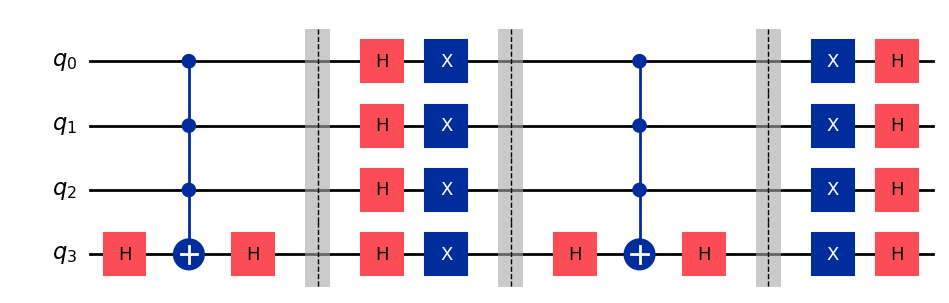

In [678]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator, QasmSimulator
from qiskit.circuit.library import MCMT, ZGate, XGate
from qiskit.primitives import StatevectorSampler 
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_distribution, plot_histogram
import math
import numpy as np
from mitiq import zne
from mitiq.interface.mitiq_qiskit.qiskit_utils import initialized_depolarizing_noise
import mthree
import matplotlib.pyplot as plt
from qiskit_ibm_runtime.fake_provider import FakePoughkeepsieV2, FakeQuitoV2
from qiskit_ibm_runtime import SamplerV2 as Sampler

from qiskit_experiments.library import LocalReadoutError, CorrelatedReadoutError

from qiskit_ibm_runtime.fake_provider import FakePerth

from qiskit.result.mitigation.utils import (
    expval_with_stddev,
    str2diag,
    counts_probability_vector
)

from qiskit_aer.noise import (
    NoiseModel,
    QuantumError,
    ReadoutError,
    depolarizing_error,
    pauli_error,
    thermal_relaxation_error,
)

noise_model = NoiseModel()
noise_thermal = NoiseModel()

readout_backend = AerSimulator(noise_model=noise_thermal)
#readout_backend = AerSimulator.from_backend(FakePerth())

#noise_model = initialized_depolarizing_noise(noise_level=0.5)
optimal_num_iterations = math.floor (
    (math.pi/4)*(math.sqrt(16))
)
grover_circuit = QuantumCircuit(4)
indices = [ind for ind in range(4)]
grover_circuit.h(3)
grover_circuit.compose(MCMT(XGate(), 3, 1), inplace=True)
grover_circuit.h(3)
grover_circuit.barrier()
for item in indices:
    grover_circuit.h(item)
for item in indices:
    grover_circuit.x(item)
grover_circuit.barrier()
grover_circuit.h(3)
grover_circuit.compose(MCMT(XGate(), 3, 1), inplace=True)
grover_circuit.h(3)
grover_circuit.barrier()
for item in indices:
    grover_circuit.x(item)
for item in indices:
    grover_circuit.h(item)
grover_circuit.draw(output="mpl", style="iqp")




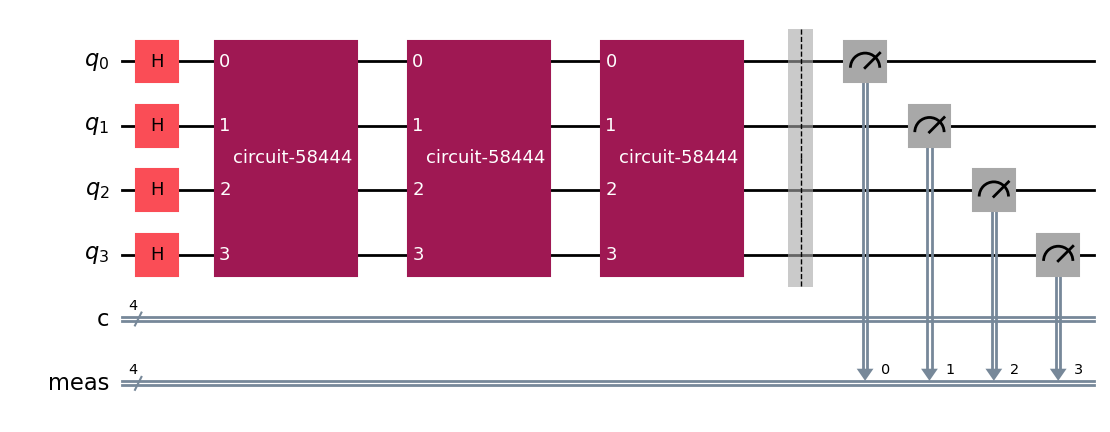

In [679]:
qc = QuantumCircuit(4,4)
for item in indices:
    qc.h(item)
qc.compose(grover_circuit.power(optimal_num_iterations), inplace=True)
qc.measure_all()
qc.draw(output="mpl", style="iqp")


In [680]:


# Example error probabilities
p_reset = 0.03
p_meas = 0.1
p_gate1 = 0.05
 
# QuantumError objects
error_reset = pauli_error([('X', p_reset), ('I', 1 - p_reset)])
error_meas = pauli_error([('X',p_meas), ('I', 1 - p_meas)])
error_gate1 = pauli_error([('X',p_gate1), ('I', 1 - p_gate1)])
error_gate2 = error_gate1.tensor(error_gate1)
 
# Add errors to noise model
noise_thermal.add_all_qubit_quantum_error(error_reset, "reset")
noise_thermal.add_all_qubit_quantum_error(error_meas, "measure")
noise_thermal.add_all_qubit_quantum_error(error_gate1, ["u1", "u2", "u3"])
noise_thermal.add_all_qubit_quantum_error(error_gate2, ["cx"])
 
 
print(noise_thermal)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'u1', 'u2', 'u3']
  Instructions with noise: ['cx', 'u3', 'u2', 'reset', 'u1', 'measure']
  All-qubits errors: ['reset', 'measure', 'u1', 'u2', 'u3', 'cx']


In [681]:
real_backend = AerSimulator.from_backend(FakeQuitoV2())
sampler = Sampler(mode=real_backend)


qc_decomposed = qc.decompose(reps=3)
qc_decomposed2 = qc_decomposed.decompose()







shots = 8192
qubits = [0,1,2,3]
num_qubits = len(qubits)
exp = LocalReadoutError(qubits)
for c in exp.circuits():
    print(c)





         ░ ┌─┐         
   q_0: ─░─┤M├─────────
         ░ └╥┘┌─┐      
   q_1: ─░──╫─┤M├──────
         ░  ║ └╥┘┌─┐   
   q_2: ─░──╫──╫─┤M├───
         ░  ║  ║ └╥┘┌─┐
   q_3: ─░──╫──╫──╫─┤M├
         ░  ║  ║  ║ └╥┘
meas: 4/════╩══╩══╩══╩═
            0  1  2  3 
        ┌───┐ ░ ┌─┐         
   q_0: ┤ X ├─░─┤M├─────────
        ├───┤ ░ └╥┘┌─┐      
   q_1: ┤ X ├─░──╫─┤M├──────
        ├───┤ ░  ║ └╥┘┌─┐   
   q_2: ┤ X ├─░──╫──╫─┤M├───
        ├───┤ ░  ║  ║ └╥┘┌─┐
   q_3: ┤ X ├─░──╫──╫──╫─┤M├
        └───┘ ░  ║  ║  ║ └╥┘
meas: 4/═════════╩══╩══╩══╩═
                 0  1  2  3 


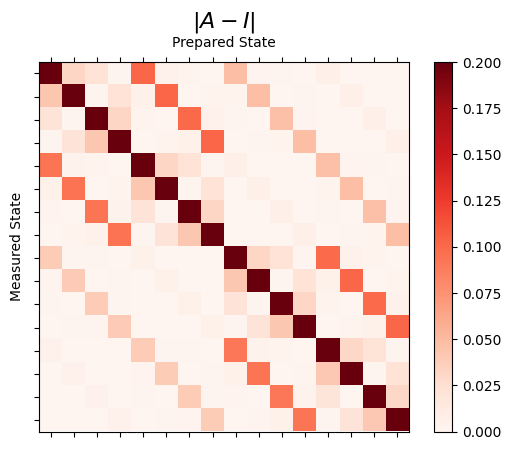

In [682]:
exp.analysis.set_options(plot=True)
result = exp.run(real_backend)
mitigator = result.analysis_results("Local Readout Mitigator").value
result.figure(0)

In [683]:
for m in mitigator._mitigation_mats:
    print(m)

[[ 1.05573419 -0.04180064]
 [-0.05573419  1.04180064]]
[[ 1.02572016 -0.02777778]
 [-0.02572016  1.02777778]]
[[ 1.13516896 -0.14643304]
 [-0.13516896  1.14643304]]
[[ 1.05228758 -0.06318083]
 [-0.05228758  1.06318083]]


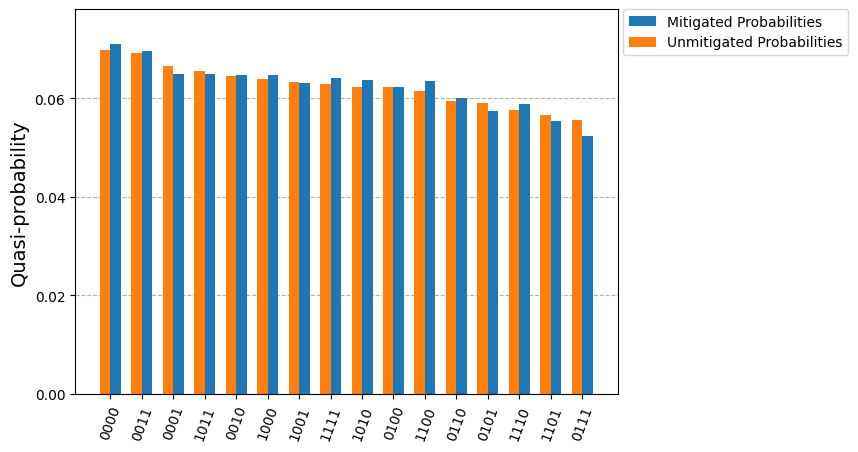

In [684]:
transpiled_qc = transpile(qc, backend=real_backend)
results = sampler.run([transpiled_qc], shots=shots).result()
dist = results[0].data.meas.get_counts()
#job = real_backend.run(transpiled_qc, shots=shots)
#counts = job.result().get_counts()
mitigated_quasi_probs = mitigator.quasi_probabilities(dist)
mitigated_stddev = mitigated_quasi_probs._stddev_upper_bound
mitigated_probs = (mitigated_quasi_probs.nearest_probability_distribution().binary_probabilities())
legend = ['Mitigated Probabilities', 'Unmitigated Probabilities']
plot_distribution([mitigated_probs, dist], legend=legend, sort="value_desc", bar_labels=False) 

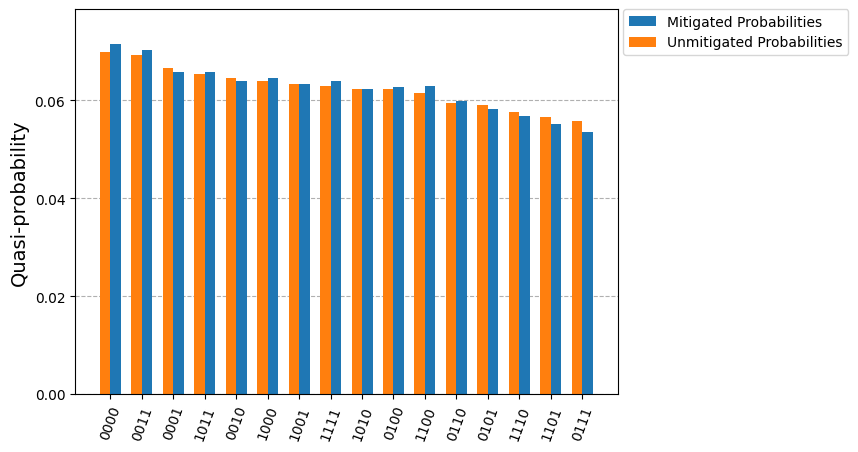

In [685]:
mappings = mthree.utils.final_measurement_mapping(transpiled_qc)
mit = mthree.M3Mitigation(real_backend)
mit.cals_from_system(mappings)
quasis = mit.apply_correction(dist, mappings)
plot_distribution([quasis, dist], legend=legend, sort="value_desc", bar_labels=False) 


In [686]:
print(dist)

{'1000': 523, '1101': 464, '0100': 510, '1001': 519, '0110': 487, '0000': 572, '0001': 545, '1111': 515, '0101': 484, '0011': 567, '0010': 529, '1011': 536, '1100': 503, '1110': 472, '1010': 510, '0111': 456}


In [687]:
print(quasis)

{'0000': 0.07143363477729156, '0001': 0.06576002142504005, '0010': 0.06391162317576228, '0011': 0.070253110655997, '0100': 0.06274140529370902, '0101': 0.05812638830886411, '0110': 0.05986730533576526, '0111': 0.05342012928254073, '1000': 0.06453150179994498, '1001': 0.06333154238825228, '1010': 0.062336134308334526, '1011': 0.0657259831448188, '1100': 0.06287029634104235, '1101': 0.055034512516081234, '1110': 0.05671735795886924, '1111': 0.06393905328768659}


In [688]:
expectation_value_unmitigated = dist.get('1111')/(shots)
expectation_value_mitigated = quasis.get('1111')
print(f"Unmitigated: {expectation_value_unmitigated}")
print(f"Mitigated: {expectation_value_mitigated}")
print(f"A percent increase of: {((expectation_value_mitigated-expectation_value_unmitigated)/(expectation_value_unmitigated))*100}")

Unmitigated: 0.0628662109375
Mitigated: 0.06393905328768659
A percent increase of: 1.706548452957003


In [689]:
shots=8192
def ibmq_executor(circuit: QuantumCircuit, shots: int=8192) -> float:
    exec_circuit = transpile(
        circuit,
        backend=backend,
        basis_gates = noise_model.basis_gates,
        optimization_level=0, # Important to preserve folded gates.
    )
    job = backend.run(circuit, shots = 8192)
    counts = job.result().get_counts()
    expectation_value = counts.get("1111") / shots
    return expectation_value
unmitigated = ibmq_executor(qc)
mitigated = zne.execute_with_zne(qc, ibmq_executor)
print(f"Unmitigated result {unmitigated:.3f}")
print(f"Mitigated result {mitigated:.3f}")

AerError: 'unknown instruction: circuit-58444'

In [ ]:

mappings = mthree.utils.final_measurement_mapping(transpiled_qc)
dist = result[0].data.meas.get_counts()
plot_distribution(dist)


TypeError: 'ExperimentData' object is not subscriptable

In [ ]:
sampler.options.twirling.enable_gates = True
sampler.options.twirling.num_randomizations = 32
sampler.options.twirling.shots_per_randomization = 100
result_mitigated = sampler.run([transpiled_qc], shots=10000).result()
dist_mitigated = result_mitigated[0].data.meas.get_counts()
mit = mthree.M3Mitigation(real_backend)
mit.cals_from_system(mappings)
quasis = mit.apply_correction(dist_mitigated, mappings)


c:\anaconda3\envs\pioneer\Lib\site-packages\qiskit_ibm_runtime\fake_provider\local_service.py:337: UserWarning: Options {'twirling': {'enable_gates': True, 'num_randomizations': 32, 'shots_per_randomization': 100}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")


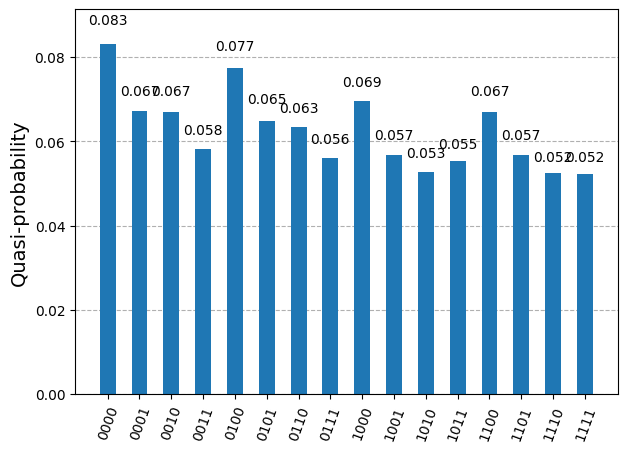

In [ ]:
plot_distribution(quasis)